In [79]:
import sys
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from keras.models import Model, Sequential
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding, GRU, Conv1D, MaxPooling1D, Flatten, SimpleRNN
from keras.optimizers import RMSprop
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras import metrics

from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve,auc

In [80]:
col_names = ["duration","protocol_type","service","flag","src_bytes",
    "dst_bytes","land","wrong_fragment","urgent","hot","num_failed_logins",
    "logged_in","num_compromised","root_shell","su_attempted","num_root",
    "num_file_creations","num_shells","num_access_files","num_outbound_cmds",
    "is_host_login","is_guest_login","count","srv_count","serror_rate",
    "srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate",
    "diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count",
    "dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
    "dst_host_rerror_rate","dst_host_srv_rerror_rate","label","difficulty_level"]

In [81]:
df = pd.read_csv('NSL-KDD\KDDTrain+_20Percent.txt', names=col_names, encoding='latin-1')

In [82]:
df.drop(['difficulty_level'],axis=1,inplace=True)

In [83]:
df.info()
print(df.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25192 entries, 0 to 25191
Data columns (total 42 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   duration                     25192 non-null  int64  
 1   protocol_type                25192 non-null  object 
 2   service                      25192 non-null  object 
 3   flag                         25192 non-null  object 
 4   src_bytes                    25192 non-null  int64  
 5   dst_bytes                    25192 non-null  int64  
 6   land                         25192 non-null  int64  
 7   wrong_fragment               25192 non-null  int64  
 8   urgent                       25192 non-null  int64  
 9   hot                          25192 non-null  int64  
 10  num_failed_logins            25192 non-null  int64  
 11  logged_in                    25192 non-null  int64  
 12  num_compromised              25192 non-null  int64  
 13  root_shell      

## Pre processing

### Hierarchy Generation

In [84]:
df.label.replace(['apache2','back','land','neptune','mailbomb','pod','processtable','smurf','teardrop','udpstorm','worm'],'Dos',inplace=True)
df.label.replace(['ftp_write','guess_passwd','httptunnel','imap','multihop','named','phf','sendmail','snmpgetattack','snmpguess','spy','warezclient','warezmaster','xlock','xsnoop'],'R2L',inplace=True)
df.label.replace(['ipsweep','mscan','nmap','portsweep','saint','satan'],'Probe',inplace=True)
df.label.replace(['buffer_overflow','loadmodule','perl','ps','rootkit','sqlattack','xterm'],'U2R',inplace=True)

### Standadization

In [85]:
#selection of numeric attribute columns from the dataset
numcol = df.select_dtypes(include = 'number').columns

from sklearn.preprocessing import StandardScaler

#normalizing using standard scalar
std_scalar = StandardScaler()
for i in numcol:
    arr = df[i]
    arr = np.array(arr)
    df[i] = std_scalar.fit_transform(arr.reshape(len(arr),1))

### One Hot Encoding

In [86]:
categ_col = ['protocol_type','service','flag']
ctg = df[categ_col]

#one-hot encoding of categorical attributes
ctg = pd.get_dummies(ctg, columns = categ_col)

### Binary Classification

This is used for all of the 4 Artificial Neural Network Algorithms since we aim to do Binary Classification of the label either as attack or normal connection.

In [87]:
#categorize attack labels into 'normal' and 'attack'
biny_lbl = pd.DataFrame(df.label.map(lambda x:'normal' if x=='normal' else 'attack'))

In [88]:
#create dataframe with binary label
bin_dataset = df.copy()
bin_dataset['label'] = biny_lbl

In [89]:
#perform label encoding with binary labels
from sklearn import preprocessing

label_one = preprocessing.LabelEncoder()
encode_label = biny_lbl.apply(label_one.fit_transform)
bin_dataset['intrusion'] = encode_label

In [90]:
#one-hot encoding of the attack label
bin_dataset = pd.get_dummies(bin_dataset, columns = ['label'], prefix = "", prefix_sep = "")
bin_dataset['label'] = biny_lbl
bin_dataset

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,intrusion,attack,normal,label
0,-0.113551,tcp,ftp_data,SF,-0.009889,-0.039310,-0.00891,-0.091223,-0.006301,-0.091933,...,0.073120,-0.287993,-0.641804,-0.627365,-0.221668,-0.374281,1,0,1,normal
1,-0.113551,udp,other,SF,-0.010032,-0.039310,-0.00891,-0.091223,-0.006301,-0.091933,...,2.375620,-0.287993,-0.641804,-0.627365,-0.385140,-0.374281,1,0,1,normal
2,-0.113551,tcp,private,S0,-0.010093,-0.039310,-0.00891,-0.091223,-0.006301,-0.091933,...,-0.478183,-0.287993,1.603834,1.614454,-0.385140,-0.374281,0,1,0,attack
3,-0.113551,tcp,http,SF,-0.009996,0.052473,-0.00891,-0.091223,-0.006301,-0.091933,...,-0.380894,0.073759,-0.574435,-0.604947,-0.385140,-0.342768,1,0,1,normal
4,-0.113551,tcp,http,SF,-0.010010,-0.034582,-0.00891,-0.091223,-0.006301,-0.091933,...,-0.478183,-0.287993,-0.641804,-0.627365,-0.385140,-0.374281,1,0,1,normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25187,-0.113551,tcp,exec,RSTO,-0.010093,-0.039310,-0.00891,-0.091223,-0.006301,-0.091933,...,-0.478183,-0.287993,-0.641804,-0.627365,2.884296,2.777041,0,1,0,attack
25188,-0.113551,tcp,ftp_data,SF,-0.009954,-0.039310,-0.00891,-0.091223,-0.006301,-0.091933,...,2.764775,1.339894,-0.641804,-0.627365,-0.385140,-0.374281,0,1,0,attack
25189,-0.113551,tcp,private,REJ,-0.010093,-0.039310,-0.00891,-0.091223,-0.006301,-0.091933,...,-0.478183,-0.287993,-0.641804,-0.627365,2.884296,2.777041,0,1,0,attack
25190,-0.113551,tcp,nnsp,S0,-0.010093,-0.039310,-0.00891,-0.091223,-0.006301,-0.091933,...,-0.478183,-0.287993,1.603834,1.614454,-0.385140,-0.374281,0,1,0,attack


### Multi-class Classification

This can be used to classify the connection as what type of attact it is. We don't use this in next 4 deep learning algorithms

In [91]:
# creating a dataframe with multi-class labels (Dos,Probe,R2L,U2R,normal)
multi_data = df.copy()
multi_label = pd.DataFrame(multi_data.label)


In [92]:
# label encoding (0,1,2,3,4) multi-class labels (Dos,normal,Probe,R2L,U2R)
labencd = preprocessing.LabelEncoder()
enc_label = multi_label.apply(labencd.fit_transform)
multi_data['intrusion'] = enc_label


In [93]:
labencd.classes_

array(['Dos', 'Probe', 'R2L', 'U2R', 'normal'], dtype=object)

In [94]:
# one-hot-encoding attack label
multi_data = pd.get_dummies(multi_data,columns=['label'],prefix="",prefix_sep="") 
multi_data['label'] = multi_label

### Feature Extraction

In [95]:
#creation of dataframe constrained to numeric attributes of encoded label attributes and binary class dataset 
numeric_bin = bin_dataset[numcol]
numeric_bin['intrusion'] = bin_dataset['intrusion']

C:\Users\dharaneish\AppData\Local\Temp\ipykernel_26328\1606513812.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  numeric_bin['intrusion'] = bin_dataset['intrusion']


In [96]:
# finding the attributes which have more than 0.5 correlation with encoded attack label attribute 
corr= numeric_bin.corr()
corr_y = abs(corr['intrusion'])
highest_corr = corr_y[corr_y >0.5]
highest_corr.sort_values(ascending=True)


count                       0.578790
srv_serror_rate             0.647817
serror_rate                 0.649952
dst_host_serror_rate        0.651050
dst_host_srv_serror_rate    0.653759
logged_in                   0.688084
dst_host_same_srv_rate      0.692212
dst_host_srv_count          0.719292
same_srv_rate               0.749237
intrusion                   1.000000
Name: intrusion, dtype: float64

In [97]:
# selecting attributes found by using pearson correlation coefficient
numeric_bin = bin_dataset[['count','srv_serror_rate','serror_rate','dst_host_serror_rate','dst_host_srv_serror_rate','logged_in','dst_host_same_srv_rate','dst_host_srv_count','same_srv_rate']]
     

In [98]:
# joining the selected attribute with the one-hot-encoded categorical dataframe
numeric_bin = numeric_bin.join(ctg)
# then joining encoded, one-hot-encoded, and original attack label attribute
bin_dataset = numeric_bin.join(bin_dataset[['intrusion','attack','normal','label']])

In [99]:
bin_dataset

,count,srv_serror_rate,serror_rate,dst_host_serror_rate,dst_host_srv_serror_rate,logged_in,dst_host_same_srv_rate,dst_host_srv_count,same_srv_rate,protocol_type_icmp,...,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH,intrusion,attack,normal,label
0,-0.720244,-0.633978,-0.640142,-0.641804,-0.627365,-0.807626,-0.779157,-0.813985,0.772109,0,...,0,0,0,0,1,0,1,0,1,normal
1,-0.624317,-0.633978,-0.640142,-0.641804,-0.627365,-0.807626,-1.157831,-1.030895,-1.320567,0,...,0,0,0,0,1,0,1,0,1,normal
2,0.334947,1.600209,1.595477,1.603834,1.614454,-0.807626,-0.935081,-0.804947,-1.388806,0,...,1,0,0,0,0,0,0,1,0,attack
3,-0.694082,-0.187141,-0.193018,-0.574435,-0.604947,1.238197,1.069663,1.264742,0.772109,0,...,0,0,0,0,1,0,1,0,1,normal
4,-0.476067,-0.633978,-0.640142,-0.641804,-0.627365,1.238197,1.069663,1.264742,0.772109,0,...,0,0,0,0,1,0,1,0,1,normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25187,0.134374,-0.633978,-0.640142,-0.641804,-0.627365,-0.807626,-1.091006,-0.976667,-1.343313,0,...,0,0,0,0,0,0,0,1,0,attack
25188,-0.728964,-0.633978,-0.640142,-0.641804,-0.627365,1.238197,1.069663,-0.687453,0.772109,0,...,0,0,0,0,1,0,0,1,0,attack
25189,0.177977,-0.633978,-0.640142,-0.641804,-0.627365,-0.807626,-1.046456,-0.922440,-1.343313,0,...,0,0,0,0,0,0,0,1,0,attack
25190,0.387271,1.600209,1.595477,1.603834,1.614454,-0.807626,-0.979631,-0.859174,-1.184088,0,...,1,0,0,0,0,0,0,1,0,attack


In [100]:

# creating a dataframe with only numeric attributes of multi-class dataset and encoded label attribute 
numeric_multi = multi_data[numcol]
numeric_multi['intrusion'] = multi_data['intrusion']

C:\Users\dharaneish\AppData\Local\Temp\ipykernel_26328\721849191.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  numeric_multi['intrusion'] = multi_data['intrusion']


In [101]:
# finding the attributes which have more than 0.5 correlation with encoded attack label attribute 
corr = numeric_multi.corr()
corr_y = abs(corr['intrusion'])
highest_corr = corr_y[corr_y >0.5]
highest_corr.sort_values(ascending=True)

count                       0.616431
logged_in                   0.692127
srv_serror_rate             0.710183
serror_rate                 0.711805
dst_host_serror_rate        0.713205
dst_host_srv_serror_rate    0.715996
dst_host_srv_count          0.716237
dst_host_same_srv_rate      0.716664
same_srv_rate               0.796708
intrusion                   1.000000
Name: intrusion, dtype: float64

In [102]:
# selecting attributes found by using pearson correlation coefficient
numeric_multi = multi_data[['count','logged_in','srv_serror_rate','serror_rate','dst_host_serror_rate','dst_host_same_srv_rate','dst_host_srv_serror_rate','dst_host_srv_count','same_srv_rate']]


In [103]:
# joining the selected attribute with the one-hot-encoded categorical dataframe
numeric_multi = numeric_multi.join(ctg)
# then joining encoded, one-hot-encoded, and original attack label attribute
multi_data = numeric_multi.join(multi_data[['intrusion','Dos','Probe','R2L','U2R','normal','label']])


In [104]:
multi_data

,count,logged_in,srv_serror_rate,serror_rate,dst_host_serror_rate,dst_host_same_srv_rate,dst_host_srv_serror_rate,dst_host_srv_count,same_srv_rate,protocol_type_icmp,...,flag_S3,flag_SF,flag_SH,intrusion,Dos,Probe,R2L,U2R,normal,label
0,-0.720244,-0.807626,-0.633978,-0.640142,-0.641804,-0.779157,-0.627365,-0.813985,0.772109,0,...,0,1,0,4,0,0,0,0,1,normal
1,-0.624317,-0.807626,-0.633978,-0.640142,-0.641804,-1.157831,-0.627365,-1.030895,-1.320567,0,...,0,1,0,4,0,0,0,0,1,normal
2,0.334947,-0.807626,1.600209,1.595477,1.603834,-0.935081,1.614454,-0.804947,-1.388806,0,...,0,0,0,0,1,0,0,0,0,Dos
3,-0.694082,1.238197,-0.187141,-0.193018,-0.574435,1.069663,-0.604947,1.264742,0.772109,0,...,0,1,0,4,0,0,0,0,1,normal
4,-0.476067,1.238197,-0.633978,-0.640142,-0.641804,1.069663,-0.627365,1.264742,0.772109,0,...,0,1,0,4,0,0,0,0,1,normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25187,0.134374,-0.807626,-0.633978,-0.640142,-0.641804,-1.091006,-0.627365,-0.976667,-1.343313,0,...,0,0,0,0,1,0,0,0,0,Dos
25188,-0.728964,1.238197,-0.633978,-0.640142,-0.641804,1.069663,-0.627365,-0.687453,0.772109,0,...,0,1,0,2,0,0,1,0,0,R2L
25189,0.177977,-0.807626,-0.633978,-0.640142,-0.641804,-1.046456,-0.627365,-0.922440,-1.343313,0,...,0,0,0,0,1,0,0,0,0,Dos
25190,0.387271,-0.807626,1.600209,1.595477,1.603834,-0.979631,1.614454,-0.859174,-1.184088,0,...,0,0,0,0,1,0,0,0,0,Dos


In [105]:
multi_data.columns

Index(['count', 'logged_in', 'srv_serror_rate', 'serror_rate',
       'dst_host_serror_rate', 'dst_host_same_srv_rate',
       'dst_host_srv_serror_rate', 'dst_host_srv_count', 'same_srv_rate',
       'protocol_type_icmp', 'protocol_type_tcp', 'protocol_type_udp',
       'service_IRC', 'service_X11', 'service_Z39_50', 'service_auth',
       'service_bgp', 'service_courier', 'service_csnet_ns', 'service_ctf',
       'service_daytime', 'service_discard', 'service_domain',
       'service_domain_u', 'service_echo', 'service_eco_i', 'service_ecr_i',
       'service_efs', 'service_exec', 'service_finger', 'service_ftp',
       'service_ftp_data', 'service_gopher', 'service_hostnames',
       'service_http', 'service_http_443', 'service_http_8001',
       'service_imap4', 'service_iso_tsap', 'service_klogin', 'service_kshell',
       'service_ldap', 'service_link', 'service_login', 'service_mtp',
       'service_name', 'service_netbios_dgm', 'service_netbios_ns',
       'service_netbios_ssn'

# Deep Learning

bin_dataset is sufficient for Deep Learning. first n-4 are x and intrusion is Y

In [106]:
'''
df2 = bin_dataset.copy()

# label encoding (0,1,2,3,4) multi-class labels (Dos,normal,Probe,R2L,U2R)
from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()
df2['label']= label_encoder.fit_transform(df2['label'])
'''


"\ndf2 = bin_dataset.copy()\n\n# label encoding (0,1,2,3,4) multi-class labels (Dos,normal,Probe,R2L,U2R)\nfrom sklearn import preprocessing\nlabel_encoder = preprocessing.LabelEncoder()\ndf2['label']= label_encoder.fit_transform(df2['label'])\n"

In [107]:
df2 = bin_dataset.copy()

In [108]:
##create input and output vectors
X = df2.iloc[:,0:df2.shape[1]-4]
Y = df2[['intrusion']]
print(X.shape)
X = X.values.reshape(df2.shape[0], df2.shape[1]-4, 1)
Y = Y.values.reshape(df2.shape[0], 1)

(25192, 89)


In [109]:
Z = Y
from keras.utils import to_categorical
Y = to_categorical(Y)
total_rows = 25192 * 4
max_len=4

In [110]:
## splitting of training and testing data
X_train,X_test,Z_train,Z_test = train_test_split(X,Z,test_size=0.20)
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.20)

X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [111]:
print(X_train.shape, Y_train.shape)

(20153, 1, 89) (20153, 2)


In [112]:
sess1 = tf.compat.v1.Session()

## CNN

Epoch 1/50
79/79 [==============================] - 3s 12ms/step - loss: 0.1758 - accuracy: 0.9468 - val_loss: 0.0963 - val_accuracy: 0.9682
Epoch 2/50
79/79 [==============================] - 1s 8ms/step - loss: 0.0832 - accuracy: 0.9715 - val_loss: 0.0789 - val_accuracy: 0.9714
Epoch 3/50
79/79 [==============================] - 1s 8ms/step - loss: 0.0745 - accuracy: 0.9743 - val_loss: 0.0763 - val_accuracy: 0.9756
Epoch 4/50
79/79 [==============================] - 1s 8ms/step - loss: 0.0710 - accuracy: 0.9767 - val_loss: 0.0776 - val_accuracy: 0.9736
Epoch 5/50
79/79 [==============================] - 1s 8ms/step - loss: 0.0673 - accuracy: 0.9778 - val_loss: 0.0699 - val_accuracy: 0.9754
Epoch 6/50
79/79 [==============================] - 1s 8ms/step - loss: 0.0653 - accuracy: 0.9786 - val_loss: 0.0685 - val_accuracy: 0.9766
Epoch 7/50
79/79 [==============================] - 1s 8ms/step - loss: 0.0637 - accuracy: 0.9787 - val_loss: 0.0660 - val_accuracy: 0.9766
Epoch 8/50
79/79 [=

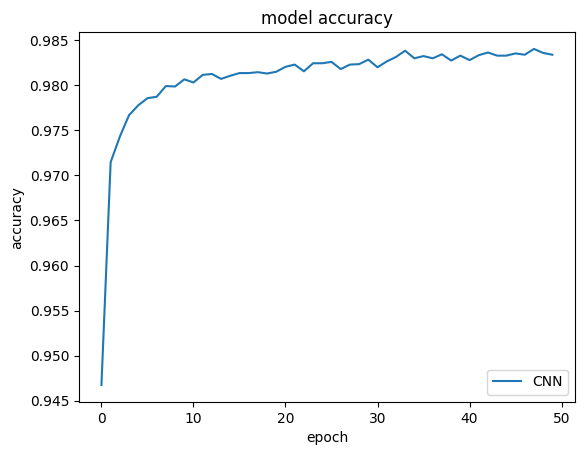

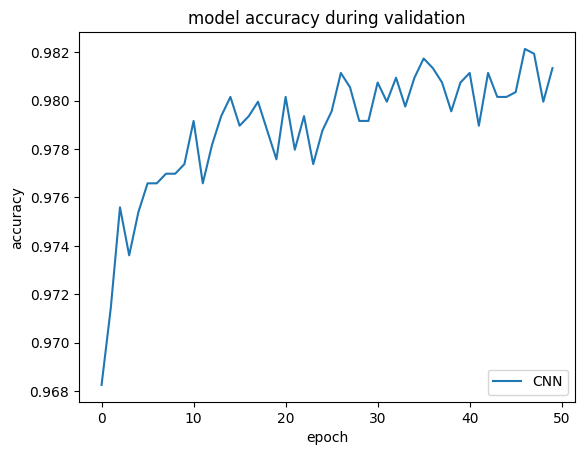

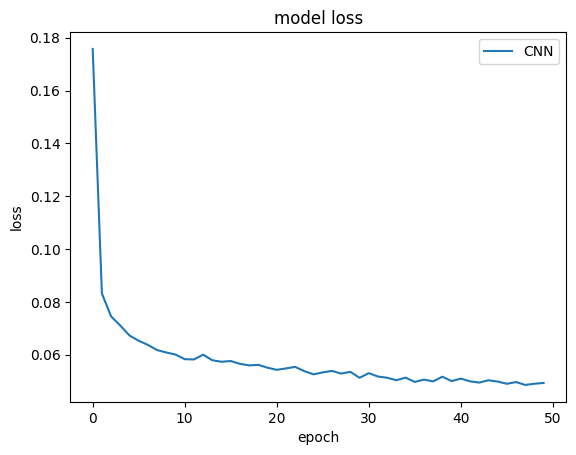

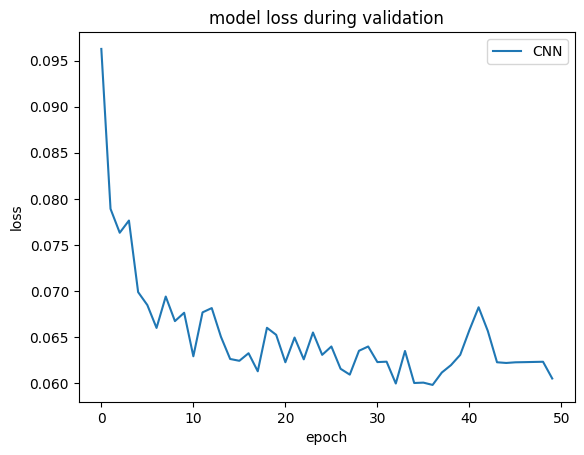

In [113]:
#CNN
model2 = Sequential()
model2.add(Conv1D(filters=256, kernel_size = 1, activation='tanh', dtype='float32', input_shape=(1,X.shape[1])))#256
model2.add(Conv1D(filters=128, kernel_size = 1, activation='tanh'))#128
model2.add(Conv1D(filters=64, kernel_size = 1, activation='tanh'))#64
model2.add(Conv1D(filters=32, kernel_size = 1, activation='tanh'))#32
model2.add(MaxPooling1D(pool_size=1))
model2.add(Flatten())
'''
model2.add(Conv1D(128, dropout=0.3, return_sequences=True)) #128
model2.add(Conv1D(64, dropout=0.3, return_sequences=True)) #64
model2.add(Conv1D(32))#32
'''
model2.add(Dense(100, activation='relu'))
model2.add((Dense(2, activation='softmax')))
model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
#checkpoint
filepath="weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

predicted2= model2.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=50, batch_size=256,callbacks=callbacks_list)

model2.summary()
scores = model2.evaluate(X_test, Y_test, verbose=2)
print("Accuracy: %.2f%%" % (scores[1]*100))
#predicted_classes = model2.predict_classes(X_test,verbose=1)
predicted_classes = (model2.predict(X_test) > 0.5).astype("int32")
print(predicted_classes.shape)
print(predicted_classes)
#probs2 = model2.predict_proba(X_test)

def predict_prob(number):
  return [number[0],1-number[0]]

probs2 = np.array(list(map(predict_prob, model2.predict(X_test))))
 
'''
top_k2 = metrics.top_k_categorical_accuracy(Y_test,probs2,k=2)
top_k_array2 = top_k2.eval(session=sess1)
print(top_k_array2)
print(top_k2)
'''

plt.plot(predicted2.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['CNN'], loc='lower right')
plt.show()


plt.plot(predicted2.history['val_accuracy'])
plt.title('model accuracy during validation')#during validation
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['CNN'], loc='lower right')
plt.show()


plt.plot(predicted2.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['CNN'], loc='upper right')
plt.show()


plt.plot(predicted2.history['val_loss'])
plt.title('model loss during validation')#during validation
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['CNN'], loc='upper right')
plt.show()


In [125]:
from keras.utils.vis_utils import plot_model
plot_model(model2, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


158/158 [==============================] - 0s 2ms/step


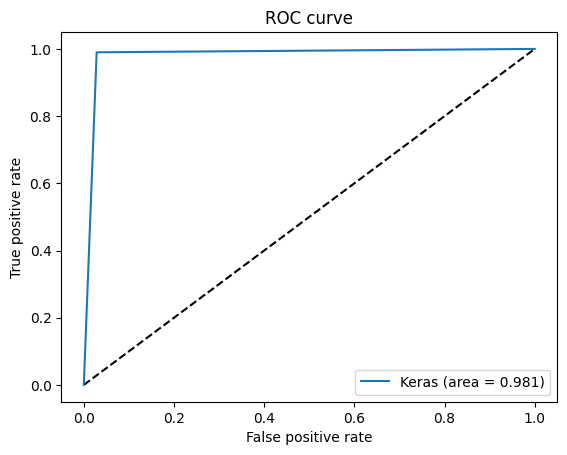

158/158 [==============================] - 0s 2ms/step
Recall Score      =     0.9899441340782122
F1 Score          =     0.9826247689463956
Precision Score   =     0.9754128440366973


In [115]:
y_pred = model2.predict(X_test)
fpr, tpr, threshold = roc_curve(Y_test.argmax(axis=1), y_pred.argmax(axis=1))
auc_v = auc(fpr, tpr)

#plot ROC for better insight on classifier
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Keras (area = {:.3f})'.format(auc_v))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

y_classes = (model2.predict(X_test)>0.5).astype('int32')
#metrics
print("Recall Score      =    ", recall_score(Y_test.argmax(axis=1),y_classes.argmax(axis=1)))
print("F1 Score          =    ", f1_score(Y_test.argmax(axis=1),y_classes.argmax(axis=1)))
print("Precision Score   =    ", precision_score(Y_test.argmax(axis=1),y_classes.argmax(axis=1)))

## RNN

Epoch 1/50
79/79 [==============================] - 7s 25ms/step - loss: 0.2211 - accuracy: 0.9214 - val_loss: 0.1246 - val_accuracy: 0.9663
Epoch 2/50
79/79 [==============================] - 1s 15ms/step - loss: 0.1557 - accuracy: 0.9481 - val_loss: 0.1105 - val_accuracy: 0.9679
Epoch 3/50
79/79 [==============================] - 1s 16ms/step - loss: 0.1472 - accuracy: 0.9500 - val_loss: 0.1016 - val_accuracy: 0.9663
Epoch 4/50
79/79 [==============================] - 1s 16ms/step - loss: 0.1407 - accuracy: 0.9516 - val_loss: 0.1023 - val_accuracy: 0.9696
Epoch 5/50
79/79 [==============================] - 1s 15ms/step - loss: 0.1351 - accuracy: 0.9532 - val_loss: 0.1033 - val_accuracy: 0.9688
Epoch 6/50
79/79 [==============================] - 1s 16ms/step - loss: 0.1323 - accuracy: 0.9535 - val_loss: 0.0913 - val_accuracy: 0.9688
Epoch 7/50
79/79 [==============================] - 1s 15ms/step - loss: 0.1305 - accuracy: 0.9553 - val_loss: 0.0939 - val_accuracy: 0.9682
Epoch 8/50
79

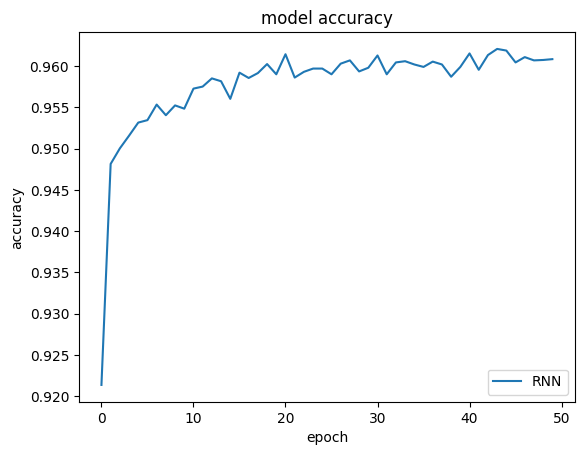

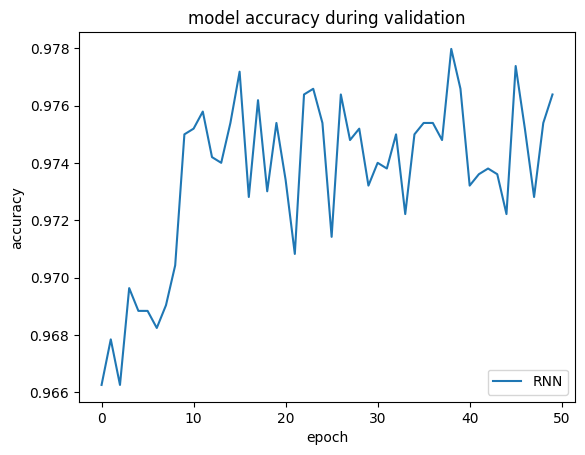

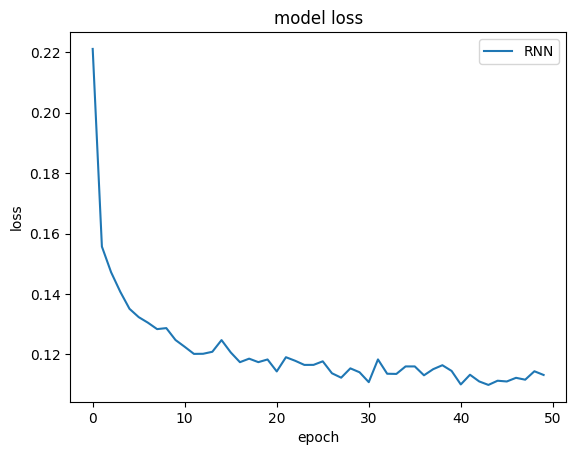

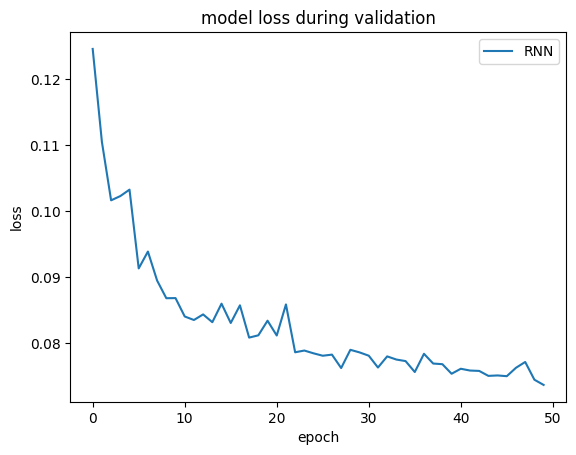

In [116]:

#create model (RNN)
model3 = Sequential()
model3.add(SimpleRNN(256, dropout=0.3, return_sequences=True, input_shape=(1,X.shape[1])))#256
model3.add(SimpleRNN(128, dropout=0.3, return_sequences=True)) #128
model3.add(SimpleRNN(64, dropout=0.3, return_sequences=True)) #64
model3.add(SimpleRNN(32))#32

'''
#(For Single Layer)
model3.add(SimpleRNN(128, dropout=0.3, return_sequences=True, input_shape=(1,4))) 
model3.add(SimpleRNN(128))
'''

model3.add((Dense(2, activation='softmax')))
model3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
#checkpoint
filepath="weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

predicted3= model3.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=50, batch_size=256,callbacks=callbacks_list)

model3.summary()
scores = model3.evaluate(X_test, Y_test, verbose=2)
print("Accuracy: %.2f%%" % (scores[1]*100))
#predicted_classes = model3.predict_classes(X_test,verbose=1)
predicted_classes = (model3.predict(X_test) > 0.5).astype("int32")
print(predicted_classes.shape)
print(predicted_classes)

#probs3 = model3.predict_proba(X_test)
def predict_prob(number):
  return [number[0],1-number[0]]

probs3 = np.array(list(map(predict_prob, model3.predict(X_test))))

'''
top_k3 = metrics.top_k_categorical_accuracy(Y_test,probs3,k=2)
top_k_array3 = top_k3.eval(session=sess1)
print(top_k_array3)
print(top_k3)
'''

plt.plot(predicted3.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['RNN'], loc='lower right')
plt.show()


plt.plot(predicted3.history['val_accuracy'])
plt.title('model accuracy during validation')#during validation
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['RNN'], loc='lower right')
plt.show()


plt.plot(predicted3.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['RNN'], loc='upper right')
plt.show()


plt.plot(predicted3.history['val_loss'])
plt.title('model loss during validation')#during validation
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['RNN'], loc='upper right')
plt.show()


158/158 [==============================] - 1s 3ms/step


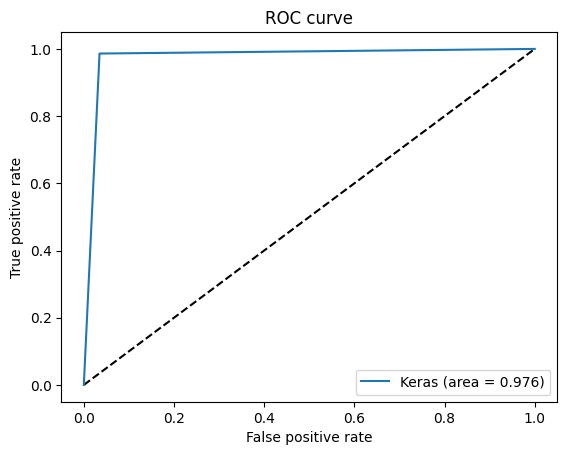

158/158 [==============================] - 1s 3ms/step
Recall Score      =     0.986219739292365
F1 Score          =     0.9780240073868882
Precision Score   =     0.96996336996337


In [117]:
y_pred = model3.predict(X_test)
fpr, tpr, threshold = roc_curve(Y_test.argmax(axis=1), y_pred.argmax(axis=1))
auc_v = auc(fpr, tpr)

#plot ROC for better insight on classifier
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Keras (area = {:.3f})'.format(auc_v))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

y_classes = (model3.predict(X_test)>0.5).astype('int32')
#metrics
print("Recall Score      =    ", recall_score(Y_test.argmax(axis=1),y_classes.argmax(axis=1)))
print("F1 Score          =    ", f1_score(Y_test.argmax(axis=1),y_classes.argmax(axis=1)))
print("Precision Score   =    ", precision_score(Y_test.argmax(axis=1),y_classes.argmax(axis=1)))

## LSTM

Epoch 1/50
79/79 [==============================] - 17s 78ms/step - loss: 0.4323 - accuracy: 0.8538 - val_loss: 0.1568 - val_accuracy: 0.9623
Epoch 2/50
79/79 [==============================] - 4s 46ms/step - loss: 0.1537 - accuracy: 0.9511 - val_loss: 0.1168 - val_accuracy: 0.9673
Epoch 3/50
79/79 [==============================] - 4s 45ms/step - loss: 0.1387 - accuracy: 0.9549 - val_loss: 0.1044 - val_accuracy: 0.9677
Epoch 4/50
79/79 [==============================] - 4s 45ms/step - loss: 0.1310 - accuracy: 0.9551 - val_loss: 0.0969 - val_accuracy: 0.9690
Epoch 5/50
79/79 [==============================] - 4s 45ms/step - loss: 0.1303 - accuracy: 0.9547 - val_loss: 0.0937 - val_accuracy: 0.9700
Epoch 6/50
79/79 [==============================] - 3s 44ms/step - loss: 0.1257 - accuracy: 0.9555 - val_loss: 0.0900 - val_accuracy: 0.9686
Epoch 7/50
79/79 [==============================] - 4s 45ms/step - loss: 0.1203 - accuracy: 0.9586 - val_loss: 0.0887 - val_accuracy: 0.9684
Epoch 8/50
7

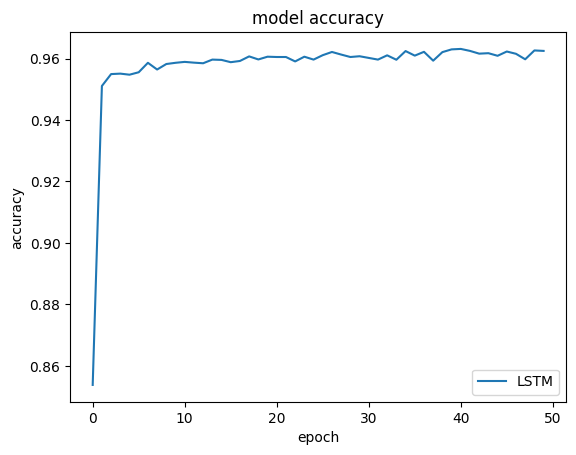

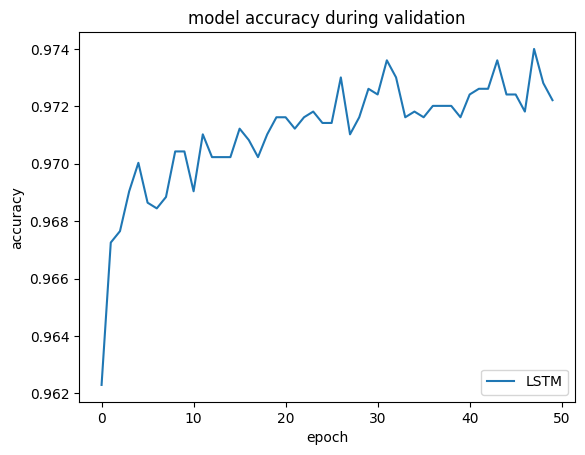

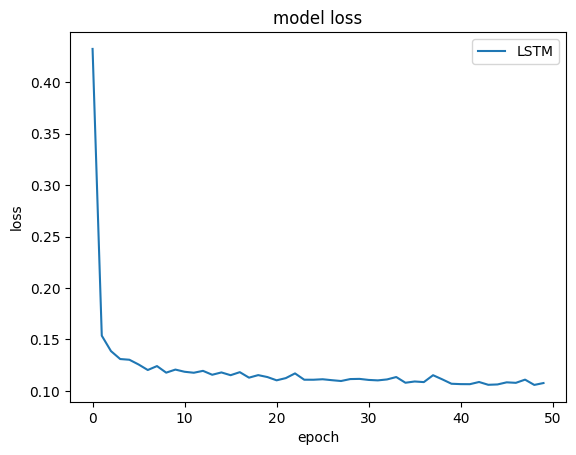

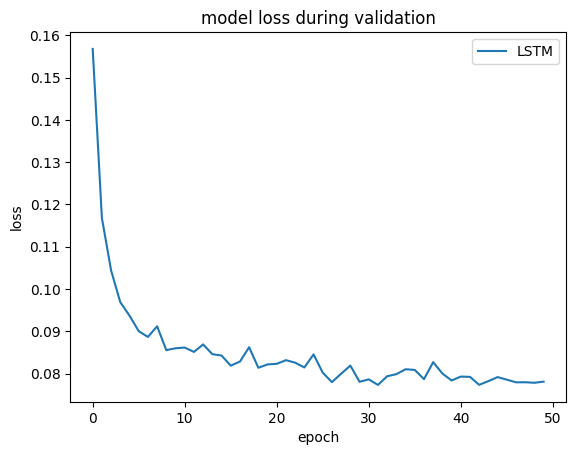

In [118]:
# create the model (LSTM)
# For stacked Layer
embedding_vecor_length = 1
model = Sequential()
model.add(LSTM(256, dropout=0.3, return_sequences=True, input_shape=(1,X.shape[1]))) #256
model.add(LSTM(128, dropout=0.3, return_sequences=True)) #128
model.add(LSTM(64, dropout=0.3, return_sequences=True)) #64
model.add(LSTM(32)) #32

'''
(For Single Layer)
model.add(LSTM(128, dropout=0.3, return_sequences=True, input_shape=(1,4))) 
model.add(LSTM(128))
'''

model.add((Dense(2, activation='softmax')))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
#checkpoint
filepath="weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

predicted1= model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=50, batch_size=256,callbacks=callbacks_list)

model.summary()
scores1 = model.evaluate(X_test, Y_test, verbose=2)
print("Accuracy: %.2f%%" % (scores1[1]*100))
#predicted_classes = model.predict_classes(X_test,verbose=1)

predicted_classes = (model.predict(X_test) > 0.5).astype("int32")
print(predicted_classes.shape)
print(predicted_classes)


#probs = model.predict_proba(X_test)
def predict_prob(number):
  return [number[0],1-number[0]]

probs = np.array(list(map(predict_prob, model.predict(X_test))))

'''
top_k = metrics.top_k_categorical_accuracy(Y_test,probs,k=2)
top_k_array = top_k.eval(session=sess1)
print(top_k_array)
print(top_k)
'''

plt.plot(predicted1.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['LSTM'], loc='lower right')
plt.show()


plt.plot(predicted1.history['val_accuracy'])
plt.title('model accuracy during validation')#during validation
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['LSTM'], loc='lower right')
plt.show()


plt.plot(predicted1.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['LSTM'], loc='upper right')
plt.show()


plt.plot(predicted1.history['val_loss'])
plt.title('model loss during validation')#during validation
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['LSTM'], loc='upper right')
plt.show()


158/158 [==============================] - 1s 5ms/step


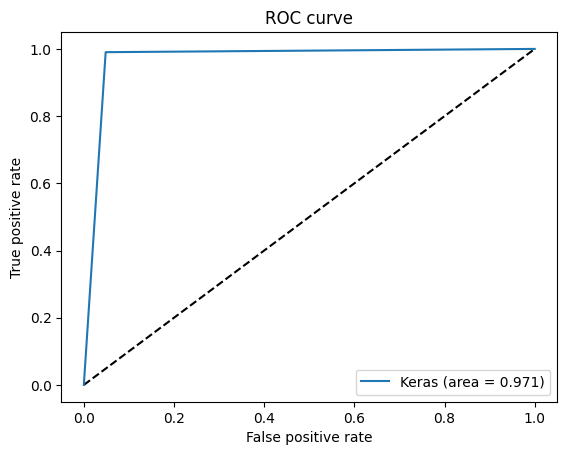

158/158 [==============================] - 1s 5ms/step
Recall Score      =     0.990316573556797
F1 Score          =     0.97434957860022
Precision Score   =     0.9588892895780743


In [119]:
y_pred = model.predict(X_test)
fpr, tpr, threshold = roc_curve(Y_test.argmax(axis=1), y_pred.argmax(axis=1))
auc_v = auc(fpr, tpr)

#plot ROC for better insight on classifier
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Keras (area = {:.3f})'.format(auc_v))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

y_classes = (model.predict(X_test)>0.5).astype('int32')
#metrics
print("Recall Score      =    ", recall_score(Y_test.argmax(axis=1),y_classes.argmax(axis=1)))
print("F1 Score          =    ", f1_score(Y_test.argmax(axis=1),y_classes.argmax(axis=1)))
print("Precision Score   =    ", precision_score(Y_test.argmax(axis=1),y_classes.argmax(axis=1)))

## GRU

Epoch 1/50
79/79 [==============================] - 15s 56ms/step - loss: 0.2955 - accuracy: 0.9081 - val_loss: 0.1325 - val_accuracy: 0.9631
Epoch 2/50
79/79 [==============================] - 3s 32ms/step - loss: 0.1505 - accuracy: 0.9508 - val_loss: 0.1126 - val_accuracy: 0.9679
Epoch 3/50
79/79 [==============================] - 2s 31ms/step - loss: 0.1349 - accuracy: 0.9548 - val_loss: 0.1074 - val_accuracy: 0.9663
Epoch 4/50
79/79 [==============================] - 3s 32ms/step - loss: 0.1356 - accuracy: 0.9525 - val_loss: 0.0976 - val_accuracy: 0.9684
Epoch 5/50
79/79 [==============================] - 3s 32ms/step - loss: 0.1289 - accuracy: 0.9535 - val_loss: 0.0937 - val_accuracy: 0.9690
Epoch 6/50
79/79 [==============================] - 2s 31ms/step - loss: 0.1275 - accuracy: 0.9550 - val_loss: 0.0939 - val_accuracy: 0.9686
Epoch 7/50
79/79 [==============================] - 3s 33ms/step - loss: 0.1254 - accuracy: 0.9561 - val_loss: 0.0902 - val_accuracy: 0.9688
Epoch 8/50
7

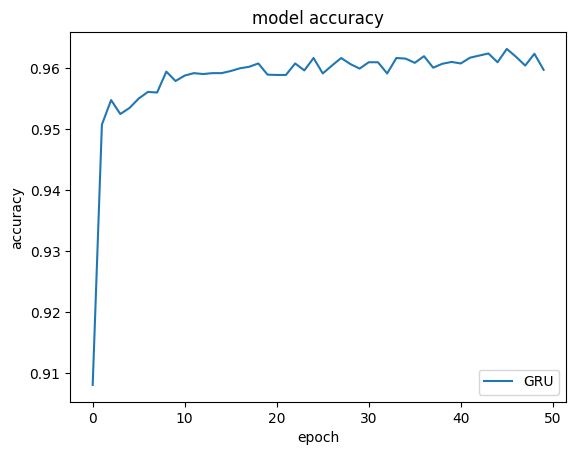

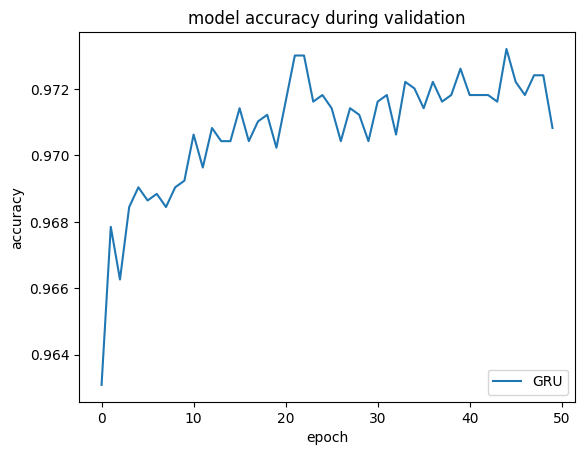

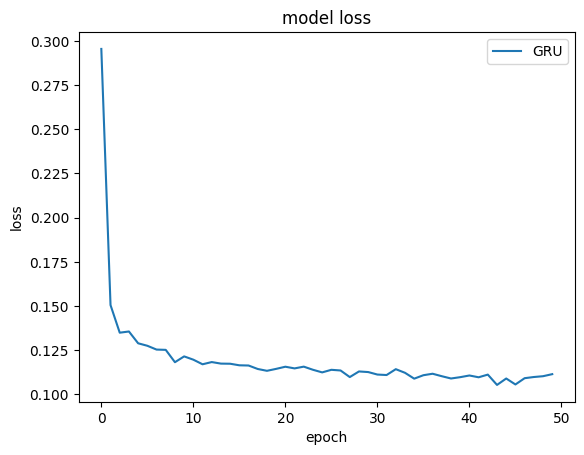

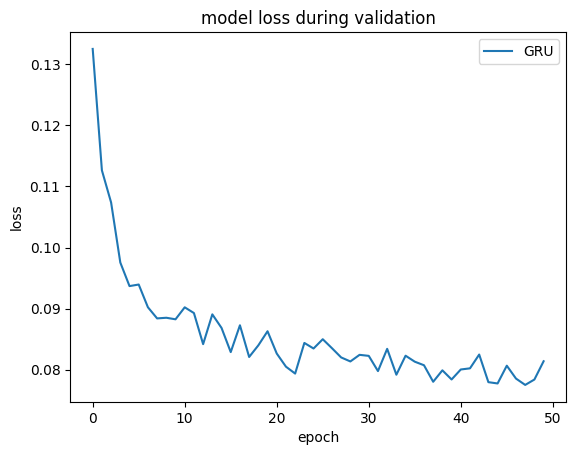

In [120]:
#create model (GRU)
# For stacked Layer
model1 = Sequential()
model1.add(GRU(256, dropout=0.3, return_sequences=True, input_shape=(1,X.shape[1])))#256
model1.add(GRU(128, dropout=0.3, return_sequences=True)) #128
model1.add(GRU(64, dropout=0.3, return_sequences=True)) #64
model1.add(GRU(32))#32

'''
(For Single Layer)
model1.add(GRU(128, dropout=0.3, return_sequences=True, input_shape=(1,4))) 
model1.add(GRU(128))
'''

model1.add((Dense(2, activation='softmax')))
model1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
#checkpoint
filepath="weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

predicted= model1.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=50, batch_size=256,callbacks=callbacks_list)

model1.summary()
scores = model1.evaluate(X_test, Y_test, verbose=2)
print("Accuracy: %.2f%%" % (scores[1]*100))

#predicted_classes = model1.predict_classes(X_test,verbose=1)

predicted_classes = (model1.predict(X_test) > 0.5).astype("int32")
print(predicted_classes.shape)
print(predicted_classes)


#probs1 = model1.predict_proba(X_test)
def predict_prob(number):
  return [number[0],1-number[0]]

probs1 = np.array(list(map(predict_prob, model1.predict(X_test))))

'''
top_k1 = metrics.top_k_categorical_accuracy(Y_test,probs1,k=2)
top_k_array1 = top_k1.eval(session=sess1)
print(top_k_array1)
print(top_k1)
'''

plt.plot(predicted.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['GRU'], loc='lower right')
plt.show()

plt.plot(predicted.history['val_accuracy'])
plt.title('model accuracy during validation')#during validation
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['GRU'], loc='lower right')
plt.show()

plt.plot(predicted.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['GRU'], loc='upper right')
plt.show()

plt.plot(predicted.history['val_loss'])
plt.title('model loss during validation')#during validation
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['GRU'], loc='upper right')
plt.show()


158/158 [==============================] - 1s 4ms/step


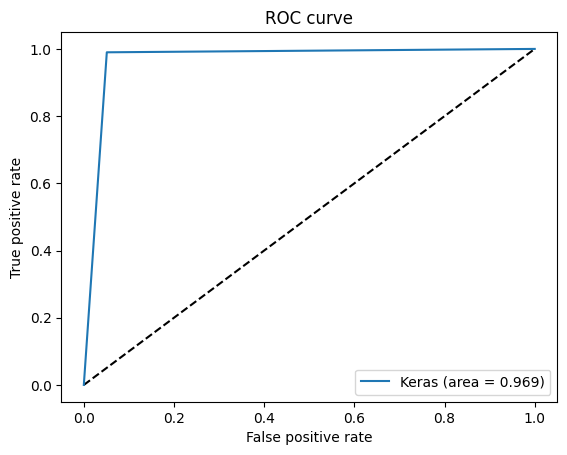

158/158 [==============================] - 1s 4ms/step
Recall Score      =     0.9899441340782122
F1 Score          =     0.9730917078528281
Precision Score   =     0.9568034557235421


In [121]:
y_pred = model1.predict(X_test)
fpr, tpr, threshold = roc_curve(Y_test.argmax(axis=1), y_pred.argmax(axis=1))
auc_v = auc(fpr, tpr)

#plot ROC for better insight on classifier
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Keras (area = {:.3f})'.format(auc_v))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

y_classes = (model1.predict(X_test)>0.5).astype('int32')
#metrics
print("Recall Score      =    ", recall_score(Y_test.argmax(axis=1),y_classes.argmax(axis=1)))
print("F1 Score          =    ", f1_score(Y_test.argmax(axis=1),y_classes.argmax(axis=1)))
print("Precision Score   =    ", precision_score(Y_test.argmax(axis=1),y_classes.argmax(axis=1)))